In [2]:
## This notebook contains what you need to assess single new sequence and compare it to existing stats

import os
from esm import pretrained, Alphabet, BatchConverter
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import string
from pathlib import Path
import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
from tqdm import tqdm
import pandas as pd
import esm
import scipy.stats as stats
import seaborn as sns


from get_biochemical_benchmarks import (
    get_basic_props,
    query # this gets some sampled stats, but could take a while to run
)

from get_perplexity_benchmarks import (
    compute_masked_perplexity_simplified,
    compute_estimated_masked_perplexity,
    compute_estimated_perplexity_by_cross_entropy
)

In [3]:
# load previous samples and stats
biochemical_sample = pd.read_csv("biochemical_benchmarks/uniprot50_biochemical_summary.csv")
global_keys = list(biochemical_sample.columns)
biochemical_stats = pd.read_csv("biochemical_benchmarks/uniprot50_biochemical_stats.csv")
print(global_keys)
biochemical_stats

['length', 'gravy', 'instability_index', 'isoelectric_point', 'aromaticity', 'charge_at_ph7', 'sequence_id']


,Unnamed: 0,length,gravy,instability_index,isoelectric_point,aromaticity,charge_at_ph7
0,count,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06
1,mean,2.848442e+02,-2.265938e-01,4.251655e+01,7.307115e+00,8.211672e-02,-1.851706e+00
2,std,3.387145e+02,4.643056e-01,1.500451e+01,2.154167e+00,3.686661e-02,1.966890e+01
3,min,1.100000e+01,-4.320000e+00,-7.686772e+01,4.050028e+00,0.000000e+00,-3.298783e+03
4,25%,1.080000e+02,-4.845361e-01,3.312532e+01,5.337261e+00,5.714286e-02,-6.097850e+00
5,50%,1.930000e+02,-2.492188e-01,4.118776e+01,6.819394e+00,7.936508e-02,-2.833196e-01
6,75%,3.480000e+02,-9.604520e-03,5.029230e+01,9.262318e+00,1.035197e-01,4.809689e+00
7,max,4.949900e+04,4.371795e+00,5.591109e+02,1.199997e+01,9.767442e-01,2.464782e+03


In [4]:
# query()

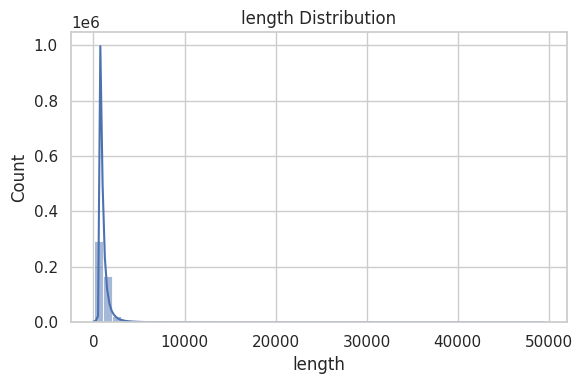

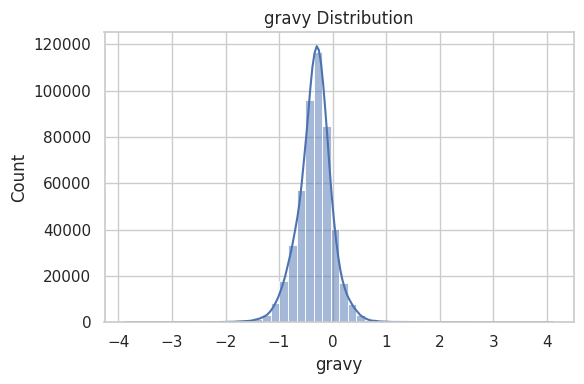

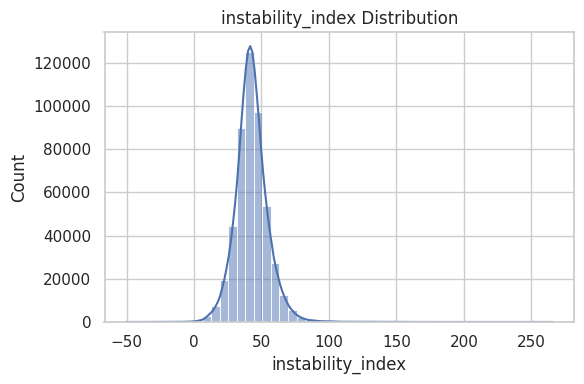

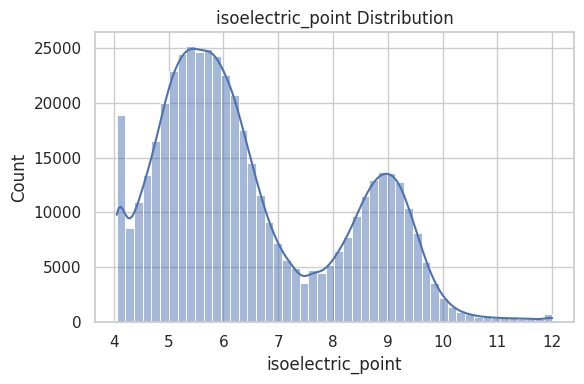

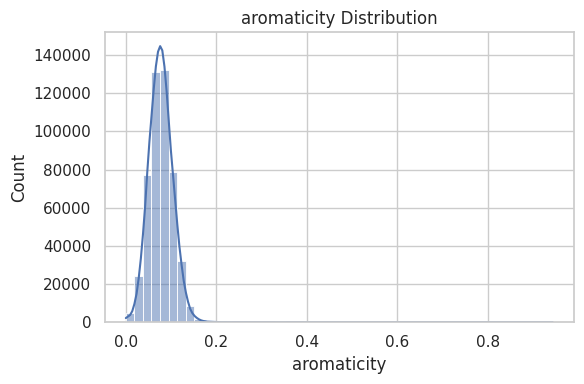

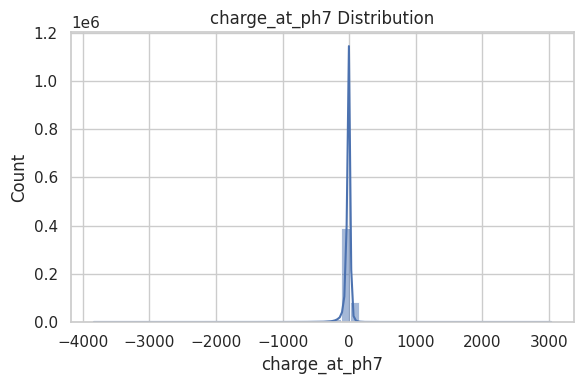

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fc2d739ee60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

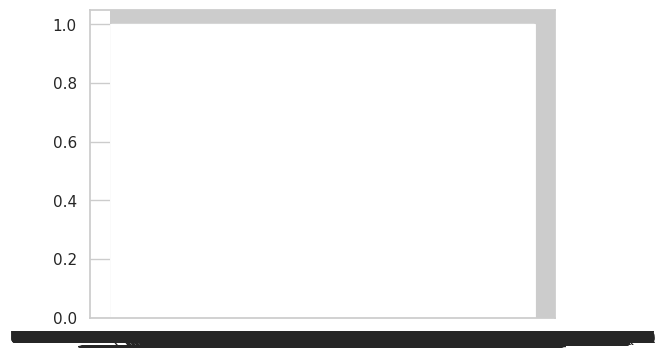

In [5]:
sns.set(style="whitegrid")
for key in global_keys:
    plt.figure(figsize=(6, 4))
    sns.histplot(biochemical_sample[key], kde=True, bins=50)
    plt.title(f"{key} Distribution")
    plt.xlabel(key)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [3]:
# load previous samples and stats
biochemical_sample = pd.read_csv("biochemical_benchmarks/uniprot50_biochemical_summary.csv")
global_keys = list(biochemical_sample.columns)
biochemical_stats = pd.read_csv("biochemical_benchmarks/uniprot50_biochemical_stats.csv")
print(global_keys)
biochemical_stats

['length', 'gravy', 'instability_index', 'isoelectric_point', 'aromaticity', 'charge_at_ph7', 'sequence_id']


,Unnamed: 0,length,gravy,instability_index,isoelectric_point,aromaticity,charge_at_ph7
0,count,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06
1,mean,2.848442e+02,-2.265938e-01,4.251655e+01,7.307115e+00,8.211672e-02,-1.851706e+00
2,std,3.387145e+02,4.643056e-01,1.500451e+01,2.154167e+00,3.686661e-02,1.966890e+01
3,min,1.100000e+01,-4.320000e+00,-7.686772e+01,4.050028e+00,0.000000e+00,-3.298783e+03
4,25%,1.080000e+02,-4.845361e-01,3.312532e+01,5.337261e+00,5.714286e-02,-6.097850e+00
5,50%,1.930000e+02,-2.492188e-01,4.118776e+01,6.819394e+00,7.936508e-02,-2.833196e-01
6,75%,3.480000e+02,-9.604520e-03,5.029230e+01,9.262318e+00,1.035197e-01,4.809689e+00
7,max,4.949900e+04,4.371795e+00,5.591109e+02,1.199997e+01,9.767442e-01,2.464782e+03


In [10]:
sample_seq = "MNYRCVKNGRKCEMIESHERKKTMVIVNYYTLQAALHMLIKATHISRVRIDKGGEAMGMQACYPNNTNTQGGPELMLSCKVAFNTAIMPQDKGPRYLLGWWPADKGDTSANRRRWGQDA"
sample_name = "Steered Zinc Finger"
new_sample = get_basic_props(sample_seq)
print(new_sample)

{'length': 119, 'gravy': -0.6252100840336137, 'instability_index': 40.847899159663854, 'isoelectric_point': 9.573248863220215, 'aromaticity': 0.07563025210084034, 'charge_at_ph7': 7.727853393388321}


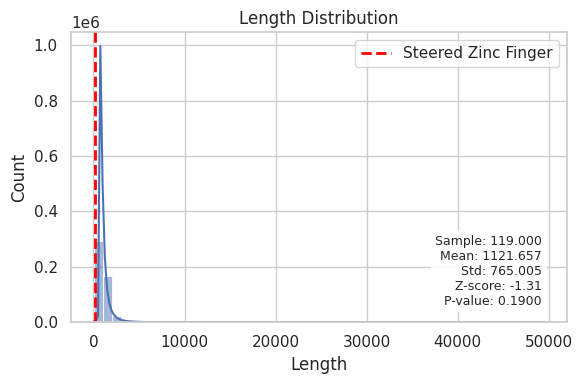

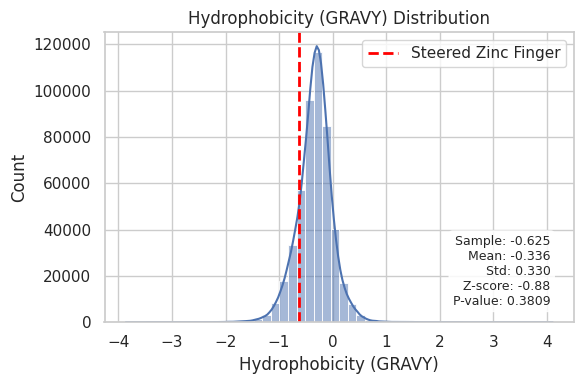

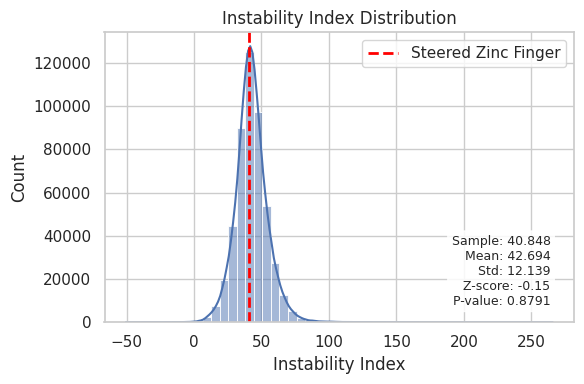

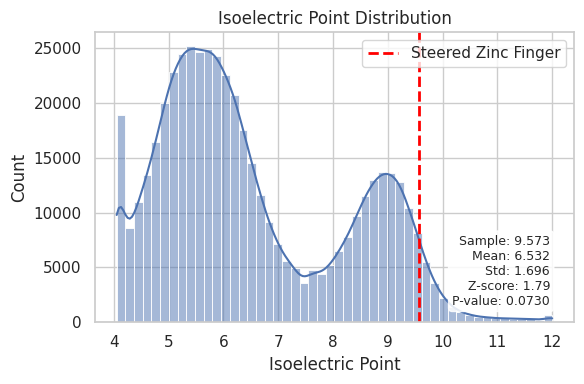

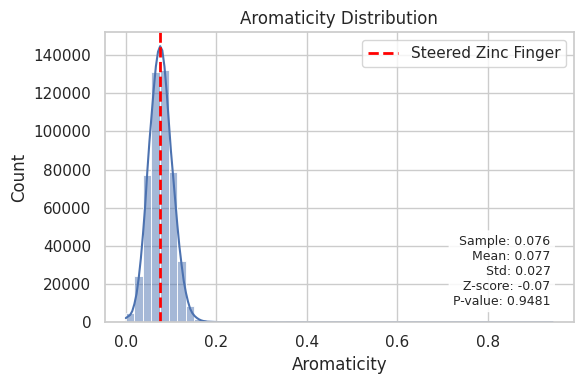

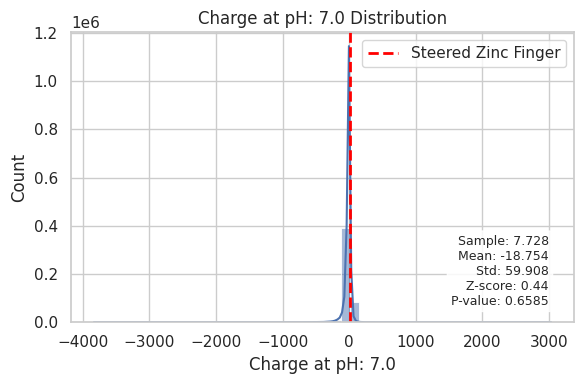

In [5]:
biokeys = [
    ('length', "Length"), 
    ('gravy', "Hydrophobicity (GRAVY)"),
    ('instability_index', "Instability Index"), 
    ('isoelectric_point', "Isoelectric Point"), 
    ('aromaticity', "Aromaticity"), 
    ('charge_at_ph7', "Charge at pH: 7.0")
    ]

sns.set(style="whitegrid")
for key in biokeys:
    values = biochemical_sample[key[0]].dropna()  # Ensure no NaNs
    new_val = new_sample[key[0]]

    # Compute stats
    mean_val = np.mean(values)
    std_val = np.std(values)
    z_score = (new_val - mean_val) / std_val
    p_value = stats.norm.sf(np.abs(z_score)) * 2  # two-sided p-value

    # Plot
    plt.figure(figsize=(6, 4))
    sns.histplot(values, kde=True, bins=50)
    plt.axvline(new_val, color='red', linestyle='--', linewidth=2, label=sample_name)
    plt.title(f"{key[1]} Distribution")
    plt.xlabel(key[1])
    plt.ylabel("Count")
    plt.legend()

    # Annotation text box
    textstr = (
        f"Sample: {new_val:.3f}\n"
        f"Mean: {mean_val:.3f}\n"
        f"Std: {std_val:.3f}\n"
        f"Z-score: {z_score:.2f}\n"
        f"P-value: {p_value:.4f}"
    )

    plt.gca().text(
        0.95, 0.05, textstr,
        transform=plt.gca().transAxes,
        fontsize=9, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
    )

    plt.tight_layout()
    plt.savefig(f"biochemical_benchmarks/new_{key[0]}_uniprot50_plot.jpg")
    plt.show()

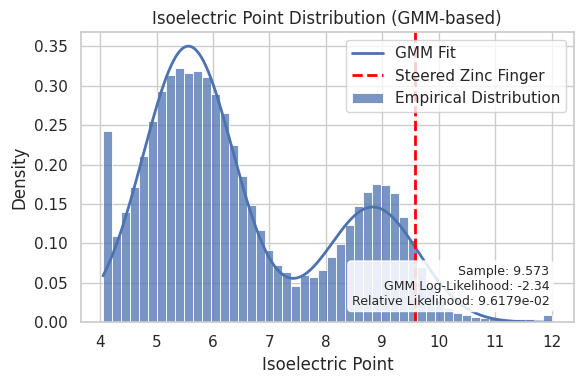

In [7]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select and reshape the data
pI_values = biochemical_sample["isoelectric_point"].dropna().values.reshape(-1, 1)
pI_sample = np.array([[new_sample["isoelectric_point"]]])

# Fit GMM with 2 components (bimodal assumption)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(pI_values)

# Score the new sample: log-likelihood under the mixture model
log_likelihood = gmm.score_samples(pI_sample)[0]
sample_prob = np.exp(log_likelihood)  # Convert log-likelihood to probability-like value

# Plotting the distribution with GMM components
x = np.linspace(pI_values.min(), pI_values.max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

plt.figure(figsize=(6, 4))
sns.histplot(pI_values.flatten(), kde=False, bins=50, stat='density', label="Empirical Distribution")
plt.plot(x, pdf, label="GMM Fit", linewidth=2)
plt.axvline(pI_sample, color='red', linestyle='--', linewidth=2, label=sample_name)

plt.title("Isoelectric Point Distribution (GMM-based)")
plt.xlabel("Isoelectric Point")
plt.ylabel("Density")
plt.legend()

textstr = (
    f"Sample: {pI_sample.item():.3f}\n"
    f"GMM Log-Likelihood: {log_likelihood:.2f}\n"
    f"Relative Likelihood: {sample_prob:.4e}"
)

plt.gca().text(
    0.95, 0.05, textstr,
    transform=plt.gca().transAxes,
    fontsize=9, verticalalignment='bottom', horizontalalignment='right',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
)

plt.tight_layout()
plt.savefig("biochemical_benchmarks/new_isoelectric_point_uniprot50_GMM_plot.jpg")
plt.show()


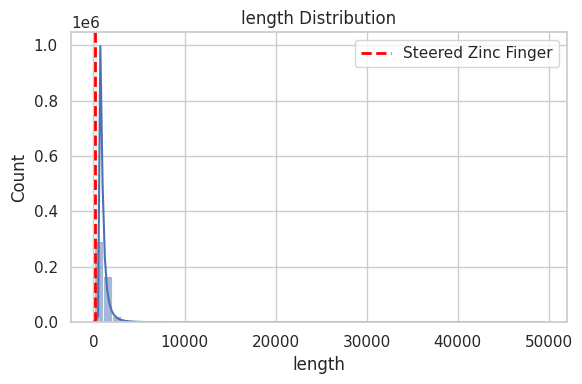

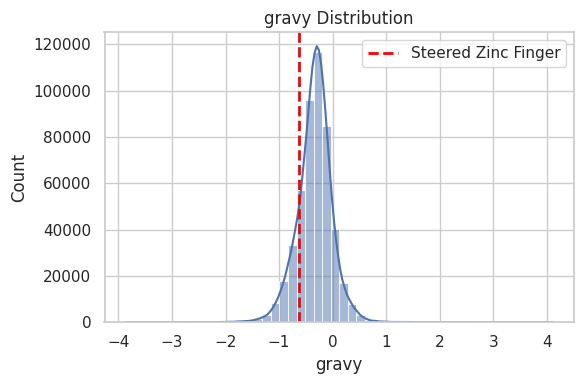

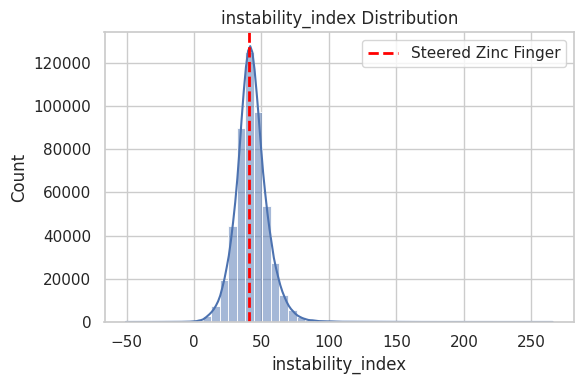

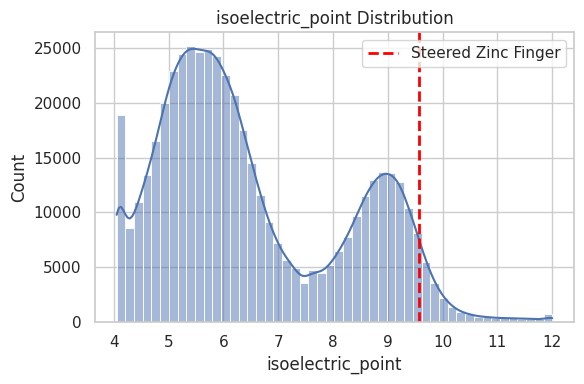

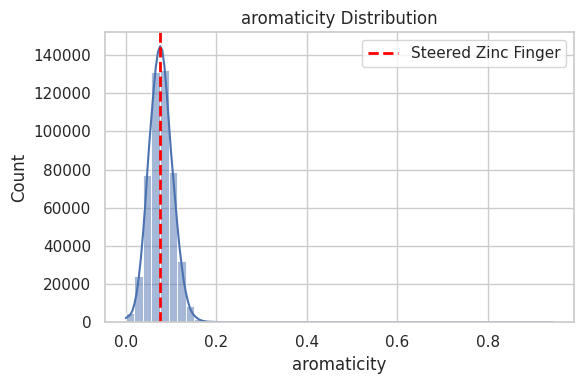

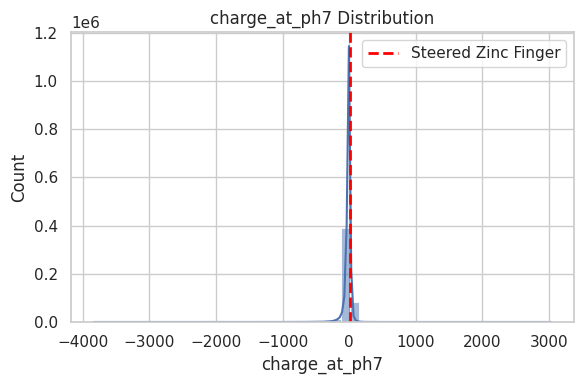

In [4]:
# Original keys and new sample
global_keys = ['length', 'gravy', 'instability_index', 'isoelectric_point', 'aromaticity', 'charge_at_ph7']

sns.set(style="whitegrid")
for key in global_keys:
    plt.figure(figsize=(6, 4))
    sns.histplot(biochemical_sample[key], kde=True, bins=50)
    plt.axvline(new_sample[key], color='red', linestyle='--', linewidth=2, label=sample_name)
    plt.title(f"{key} Distribution")
    plt.xlabel(key)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
# Perplexity Stats
df = pd.read_csv("biochemical_benchmarks/perplexity_sample_1.csv", names=["Id", "Perplexity", "Sequence"])
df_stats = pd.read_csv("biochemical_benchmarks/perplexity_sample_1_simple_stats.csv")
df.columns

Index(['Id', 'Perplexity', 'Sequence'], dtype='object')

In [8]:
perplexities = df["Perplexity"].to_list()
perplexities

[14.005868684312398,
 8.43289377169214,
 12.60533095247349,
 15.91475510021316,
 14.549625975169718,
 19.154367836387944,
 16.364390328552997,
 8.97822019301981,
 5.494625239546624,
 18.303697242505635,
 8.12910755650992,
 12.123106379965114,
 11.503679388614051,
 14.615912018891851,
 9.284849726015237,
 10.780146934894129,
 14.297056914807298,
 13.807976811044815,
 8.203163680844014,
 14.238562129044947,
 15.705137855277428,
 9.29274646536969,
 6.386132877614155,
 15.072962385554945,
 8.093947691645722,
 10.64866766556894,
 8.812925053956219,
 10.191979073590124,
 13.325120277252228,
 12.800388600888336,
 3.3835265435010413,
 12.235713714793745,
 4.861930712728551,
 10.994618365606724,
 4.386712585558219,
 13.523600610338466,
 12.986269502887772,
 15.805838945654076,
 10.065666376100753,
 6.728559179657189,
 10.321109360446956,
 16.61482717554839,
 14.555826371479938,
 4.319609656365025,
 9.089674330192512,
 11.074006401074422,
 12.3497025710166,
 9.53171200626895,
 9.74135213092326,


In [12]:
# Convert to numpy array
perplexities_np = np.array(perplexities)
new_sample_score = compute_estimated_masked_perplexity(sample_seq)

# Compute stats
mean_ppl = np.mean(perplexities_np)
std_ppl = np.std(perplexities_np)
z_score = (new_sample_score - mean_ppl) / std_ppl
p_value = stats.norm.sf(z_score)  # one-sided: P(X > new_sample)

print(f"Mean: {mean_ppl:.2f}, Std: {std_ppl:.2f}")
print(f"New sample perplexity: {new_sample_score:.2f}")
print(f"Z-score: {z_score:.2f}")
print(f"P-value: {p_value:.4f}")

Mean: 13.72, Std: 3.43
New sample perplexity: 20.33
Z-score: 1.93
P-value: 0.0269


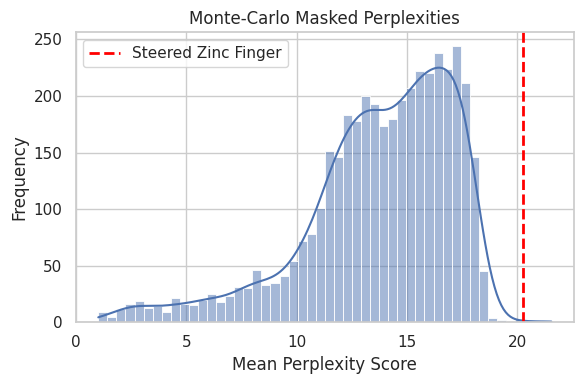

<Figure size 640x480 with 0 Axes>

In [14]:
sample_seq = "MNYRCVKNGRKCEMIESHERKKTMVIVNYYTLQAALHMLIKATHISRVRIDKGGEAMGMQACYPNNTNTQGGPELMLSCKVAFNTAIMPQDKGPRYLLGWWPADKGDTSANRRRWGQDA"
new_sample_score = compute_estimated_masked_perplexity(sample_seq, lambda_t=10, num_samples=100)

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.histplot(perplexities, bins=50, kde=True)
plt.axvline(new_sample_score, color='red', linestyle='--', linewidth=2, label='Steered Zinc Finger')
plt.title("Monte-Carlo Masked Perplexities")
plt.xlabel("Mean Perplexity Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("new_zinc_finger_stats_relative.jpg")


In [17]:
import subprocess

def run_foldx_stability(pdb_path):
    repaired_pdb = f"Repair_{pdb_path}"
    subprocess.run(["foldx_20251231", "--command=RepairPDB", "--pdb=" + pdb_path])
    subprocess.run(["foldx_20251231", "--command=Stability", "--pdb=" + repaired_pdb])

In [26]:
import subprocess
import shutil
import os

def run_foldx_stability(pdb_path):
    # Get the filename only
    pdb_filename = os.path.basename(pdb_path)

    # Copy the PDB file to the current directory
    #shutil.copy(pdb_path, pdb_filename)

    # Run RepairPDB
    subprocess.run(["foldx_20251231", "--command=RepairPDB", "--pdb=" + pdb_filename])

    # The repaired file will be named Repair_<pdb_filename>
    repaired_pdb = f"Repair_{pdb_filename}"

    # Run Stability on the repaired file
    subprocess.run(["foldx_20251231", "--command=Stability", "--pdb=" + repaired_pdb])


In [27]:
fxout = run_foldx_stability("steered_esmfold_structure.pdb")


   ********************************************
   ***                                      ***
   ***             FoldX 4.1 (c)            ***
   ***                                      ***
   ***     code by the FoldX Consortium     ***
   ***                                      ***
   ***     Jesper Borg, Frederic Rousseau   ***
   ***    Joost Schymkowitz, Luis Serrano   ***
   ***    Peter Vanhee, Erik Verschueren    ***
   ***     Lies Baeten, Javier Delgado      ***
   ***       and Francois Stricher          ***
   *** and any other of the 9! permutations ***
   ***   based on an original concept by    ***
   ***   Raphael Guerois and Luis Serrano   ***
   ********************************************

Start RepairPDB >>>

1 models read: steered_esmfold_structure.pdb
Repair will take all residues into account
Error, can't open rotabase.txt
   ********************************************
   ***                                      ***
   ***             FoldX 4.1 (c)           